### JAX



In [101]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

key = random.PRNGKey(0)
x = random.normal(key, (10,))
print(x)

[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [102]:
size = 3000
x = random.normal(key, (size, size), dtype=jnp.float32)
%timeit jnp.dot(x, x.T).block_until_ready()  # runs on the GPU

135 ms ± 428 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Averaging Stencil


In [83]:
print([i for i in range(-1,2)])

[-1, 0, 1]


In [92]:
import numpy as np

DIM = 24
SHWIDTH = 5
input_ar = np.random.rand(DIM,DIM)
output_ar = np.zeros([DIM,DIM],dtype=np.float64)

In [88]:
for x in range(SHWIDTH, DIM-SHWIDTH):
    for y in range(SHWIDTH, DIM-SHWIDTH):
        partial = 0.0
        for xs in range (-1*SHWIDTH, SHWIDTH+1):
            for ys in range (-1*SHWIDTH, SHWIDTH+1):
                    partial += input_ar[x+xs,y+ys]         
            output_ar[x,y] = partial/((2*SHWIDTH+1)*(2*SHWIDTH+1));

In [100]:
import jax.numpy as jnp
from jax import jit, vmap
from jax import random

key = random.PRNGKey(0)
input_ar = random.normal(key, (DIM,DIM))

output_ar = jnp.zeros([DIM,DIM],dtype=jnp.float32)

def loops(input_ar, output_ar, SWIDTH):
    for x in range(SHWIDTH, DIM-SHWIDTH):
        for y in range(SHWIDTH, DIM-SHWIDTH):
            partial=0.0
            for xs in range (-1*SHWIDTH, SHWIDTH+1):
                for ys in range (-1*SHWIDTH, SHWIDTH+1):
                    partial += input_ar[x+xs,y+ys]         
            output_ar.at[x,y].set(partial/((2*SHWIDTH+1)*(2*SHWIDTH+1)));
            
loops_jit = jit(loops)

loops_jit(input_ar, output_ar, SWIDTH)

AttributeError: 'NoneType' object has no attribute 'block_until_ready'

In [99]:
%%timeit
loops_jit(input_ar, output_ar, SWIDTH).block_until_ready()

AttributeError: 'NoneType' object has no attribute 'block_until_ready'

In [98]:
%%timeit
loops(input_ar, output_ar, SWIDTH)

9.29 s ± 42.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
gmat = nx.to_numpy_matrix(G)

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))
outmat

array([[0., 2., 1., 2., 3.],
       [0., 0., 1., 2., 3.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 3.],
       [0., 0., 0., 0., 0.]])

Now generate a big graph and we'll start our performance analysis. Let's look at a serial version on a graph with 1000 nodes and about 5 outbound edges per node. 

Serial program to calculate mutual outlinks.

9881

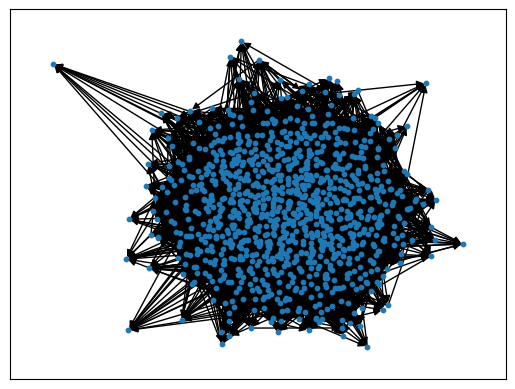

In [34]:
# cycles disappear when p = log(n)/n
G= nx.erdos_renyi_graph(1000,0.01,directed=True)
nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=False, node_size=10)
G.number_of_edges()

In [35]:
import numpy as np

gmat = nx.to_numpy_matrix(G)

outmat = np.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))
        
np.count_nonzero(outmat)

46674

In [36]:
%%timeit
for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):        
        outmat[i,j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))

3.01 s ± 8.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


That's again our serial implementation. Let's see what JAX can do.
How about a list comprehension version.

In [37]:
npd = lambda x, y : np.dot(np.asarray(gmat[x,:]).reshape(-1), np.asarray(gmat[y,:]).reshape(-1))
        
outmat = [ npd(i,j) for i in range(gmat.shape[0]) for j in range(i+1,gmat.shape[1]) ] 

np.count_nonzero(outmat)

46674

In [38]:
%%timeit
outmat2 = [ npd(i,j) for i in range(gmat.shape[0]) for j in range(i+1,gmat.shape[1]) ] 

3.02 s ± 33.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### JAX -- Jit

First simple conversion.  This copies the Jax immutable array.  Gonna be slow.

In [28]:
import jax.numpy as jnp

gmat = jnp.asarray(nx.to_numpy_matrix(G))

outmat = jnp.zeros(gmat.shape)

for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):
        outmat = outmat.at[i,j].set(jnp.dot(jnp.asarray(gmat[i,:]).reshape(-1), jnp.asarray(gmat[j,:]).reshape(-1)))

np.count_nonzero(outmat)

9

In [29]:
%%timeit
outmat = jnp.zeros(gmat.shape)
for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):
        outmat = outmat.at[i,j].set(jnp.dot(jnp.asarray(gmat[i,:]).reshape(-1), jnp.asarray(gmat[j,:]).reshape(-1)))

11.9 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
Do it in a list comprehension.

In [39]:
gmat = jnp.asarray(nx.to_numpy_matrix(G))
jnpd = lambda x, y : jnp.dot(np.asarray(gmat[x,:]).reshape(-1), jnp.asarray(gmat[y,:]).reshape(-1))
        
outmat = [ jnpd(i,j) for i in range(gmat.shape[0]) for j in range(i+1,gmat.shape[1]) ] 

np.count_nonzero(outmat)

46674

In [31]:
%%timeit
outmat = [ jnpd(i,j) for i in range(gmat.shape[0]) for j in range(i+1,gmat.shape[1]) ] 

5.47 ms ± 90.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
Is it the copy?

In [33]:
%%timeit
[ jnpd(i,j) for i in range(gmat.shape[0]) for j in range(i+1,gmat.shape[1]) ]

5.59 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
outmat = np.zeros(gmat.shape)

npd = lambda x, y : np.dot(np.asarray(gmat[x,:]).reshape(-1), np.asarray(gmat[y,:]).reshape(-1))
      
#for i in range(gmat.shape[0]):
#    for j in range(i+1,gmat.shape[1]):        
outmat = [ npd(i,j) for i in range(gmat.shape[0]) for j in range(i+1,gmat.shape[1]) ] 

np.count_nonzero(outmat)

9

In [ ]:
import jax.numpy as jnp

def comp_inner_loop(i):

    partial_out = [ np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))
                     for j in range(i+1,gmat.shape[1])]
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))  
    return partial_out

gmat = nx.to_numpy_matrix(G)

outmat = jnp.zeros(gmat.shape)

def
for i in range(gmat.shape[0]):
    for j in range(i+1,gmat.shape[1]):
        outmat = outmat.at[i,j].set(jnp.dot(jnp.asarray(gmat[i,:]).reshape(-1), jnp.asarray(gmat[j,:]).reshape(-1)))

np.count_nonzero(outmat)

In [ ]:
Jit compile with Jax.

In [ ]:
from numba import jit

outmat = np.zeros(gmat.shape)

@jit(nopython=True)
def comp_inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))  
    return partial_out
    
for i in range(gmat.shape[0]):
    outmat[i,:] = comp_inner_loop(i)

np.count_nonzero(outmat)

In [ ]:
%%timeit
for i in range(gmat.shape[0]):
    outmat[i,:] = comp_inner_loop(i)

OK, that is great. Let's try to compile the whole thing.

In [ ]:
from numba import jit, prange

@jit(nopython=True)
def comp_inner_loop(i):
    partial_out = np.zeros(gmat.shape[1])
    for j in range(i+1,gmat.shape[1]):    
        partial_out[j] = np.dot(np.asarray(gmat[i,:]).reshape(-1), np.asarray(gmat[j,:]).reshape(-1))  
   # print(partial_out)
    return partial_out

# Gotta be in a function to compile
@jit(nopython=True)    
def comp_outerloop(outmat):

    for i in prange(gmat.shape[0]):
        outmat[i,:] = comp_inner_loop(i)


outmat = np.zeros(gmat.shape)
comp_outerloop(outmat)
np.count_nonzero(outmat)

In [ ]:
%%timeit
comp_outerloop(outmat)

OK that helped some. Not as much. I expect it's a tradeoff between having to move the matrix into the argument list. This is needed because global variables are read-only, i.e. if you try and write to a global outmat it is an error.

So, compiling the inner loop is powerful.  How about parallel?

In [ ]:
from joblib import Parallel, delayed
partials = Parallel(n_jobs=4)(delayed(comp_inner_loop)(i) for i in range(gmat.shape[0]))

outmat = np.array(partials)
np.count_nonzero(outmat)

In [ ]:
%%timeit
Parallel(n_jobs=4)(delayed(comp_inner_loop)(i) for i in range(gmat.shape[0]))

That is **SLOWER**!!!  What happened?

The creation of the list is in Python and not compiled. So the creation of the delayed work takes longer than compiled code.

### Conclusions:

  * JIT Compilation is a powerful tool
  * JIT can only speed up the code that is compiled 
  * Parallelizing slow Python may not produce results as good as serial compiled.
 
Amdahl's law applies. Let's take a look at our performance results.


In [ ]:
import pandas as pd

# get values from code
d = { 'loops': [5610], 'joblib': [3290], 'inner compiled': [132], 'all compiled': [122], 'compiled+joblib' : [1570] }

df = pd.DataFrame (data=d)
df.head()
df.plot.bar()